In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from matplotlib import rcParams
from ForceMapping import forceMapping as fm
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)

In [6]:
data_for_train = np.loadtxt('data_for_train.csv', delimiter=',')
data_for_train.shape

(7140, 40)

In [7]:
period = 140

In [8]:
Joint_pos = data_for_train[:,0:4]
Joint_tor = data_for_train[:,16:20]
RF_GRF = data_for_train[:,32:34]

In [9]:
# Create scaler and fit
scaler = MinMaxScaler(feature_range=(-1, 1))
Joint_tor_scaled = scaler.fit_transform(Joint_tor.reshape(-1,1)).reshape(-1,4)

#### simple esn test

In [11]:
tor_for_train = Joint_tor[:period*41,:]
grf_for_train = RF_GRF[:period*41,:]

tor_for_val = Joint_tor[period*41:period*46,:]
grf_for_val = RF_GRF[period*41:period*46,:]


tor_for_test = Joint_tor[period*46:,:]
grf_for_test = RF_GRF[period*46:,:]


In [45]:
# Define the objective function for optimization
def objective(trial):
    # Hyperparameter space defined for Bayesian optimization
    spectral_radius = trial.suggest_float('spectral_radius', 0.8, 0.95)
    leak_rate = trial.suggest_float('leak_rate', 0.1, 0.95)
    reservoir_size = trial.suggest_int('reservoir_size', 50, 500)
    sparsity = trial.suggest_float('sparsity', 0.01, 0.5)
    
    # Create ESN model with the trial parameters
    esn = ESN(input_size=4, reservoir_size=reservoir_size, output_size=2,
              spectral_radius=spectral_radius, sparsity=sparsity, leak_rate=leak_rate)
    
    # Training data (using random data for this example)
    X_train = tor_for_train  # 1000 samples, 10 features
    y_train = grf_for_train   # 1000 target values
    
    # Fit the model
    esn.fit(X_train, y_train, washout=50, ridge_lambda=1e-6)
    
    # Validation data (using random data for this example)
    X_val = tor_for_val  # 200 samples, 10 features
    y_val = grf_for_val   # 200 target values
    
    # Make predictions and calculate MSE
    y_pred = esn.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    
    return mse

In [46]:
# Create and run the study
study = optuna.create_study(direction='minimize')  # We want to minimize the MSE
study.optimize(objective, n_trials=100)  # Run 100 trials

[I 2025-05-27 21:44:27,925] A new study created in memory with name: no-name-a3bb12cf-ea48-40b9-8ab4-aefe9547fd62
[I 2025-05-27 21:44:28,081] Trial 0 finished with value: 0.22282773518328863 and parameters: {'spectral_radius': 0.9007726537342092, 'leak_rate': 0.28479272677307255, 'reservoir_size': 160, 'sparsity': 0.48779219947686003}. Best is trial 0 with value: 0.22282773518328863.
[I 2025-05-27 21:44:28,651] Trial 1 finished with value: 0.19764449180262042 and parameters: {'spectral_radius': 0.9467405768206919, 'leak_rate': 0.6185285624942601, 'reservoir_size': 489, 'sparsity': 0.2283221487036317}. Best is trial 1 with value: 0.19764449180262042.
[I 2025-05-27 21:44:28,823] Trial 2 finished with value: 0.20531939410372918 and parameters: {'spectral_radius': 0.9413902005821416, 'leak_rate': 0.36416420539590344, 'reservoir_size': 169, 'sparsity': 0.39159519621051725}. Best is trial 1 with value: 0.19764449180262042.
[I 2025-05-27 21:44:29,157] Trial 3 finished with value: 0.1957653737

In [47]:
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'spectral_radius': 0.8232896831961476, 'leak_rate': 0.26667795253204196, 'reservoir_size': 331, 'sparsity': 0.38344428704582995}


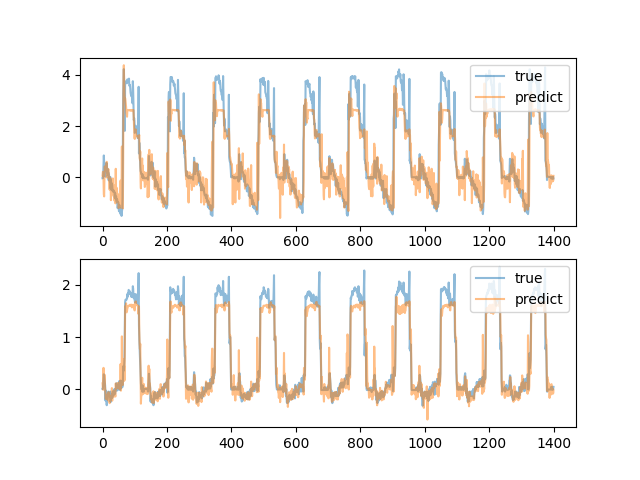

### Opitmize the hyper-parameter of ESN

In [48]:
import json

In [49]:
# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'spectral_radius': 0.8232896831961476, 'leak_rate': 0.26667795253204196, 'reservoir_size': 331, 'sparsity': 0.38344428704582995}


#### Save the best parameter

In [50]:
# Save best_params to a JSON file
with open('best_params.json', 'w') as f:
    json.dump(best_params, f)

In [51]:
best_params

{'spectral_radius': 0.8232896831961476,
 'leak_rate': 0.26667795253204196,
 'reservoir_size': 331,
 'sparsity': 0.38344428704582995}

In [52]:
esn_optimal = ESN(4, best_params['reservoir_size'], 2, best_params['spectral_radius'],  best_params['sparsity'],  best_params['leak_rate'])
esn_optimal.fit(tor_for_train, grf_for_train)


In [53]:
grf_predicted = esn_optimal.predict(tor_for_test)

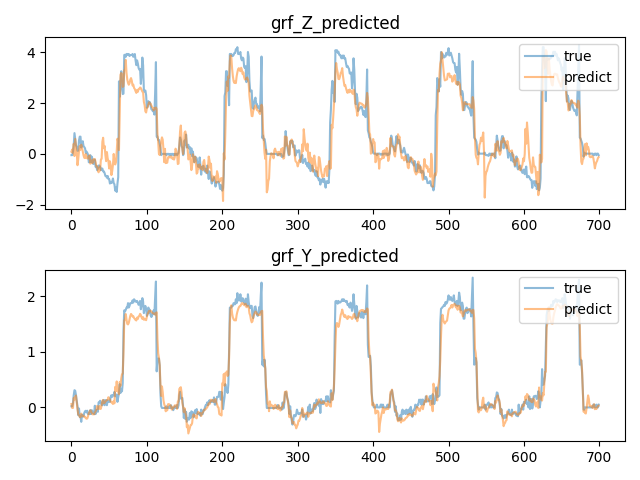

In [54]:
plt.close('all')
plt.subplot(2,1,1)
plt.plot(grf_for_test[:,0], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:,0], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Z_predicted')

plt.subplot(2,1,2)
plt.plot(grf_for_test[:,1], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_predicted[:,1], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Y_predicted')
plt.tight_layout()

### Test the prediction performance for RF limb 

In [28]:
RF_limb = np.load('RF_limb.npy')
RF_limb.shape

(4200, 40)

In [55]:
Joint_pos_rf = RF_limb[:,0:4]
Joint_tor_rf = RF_limb[:,16:20]
RF_GRF_rf = RF_limb[:,32:34]

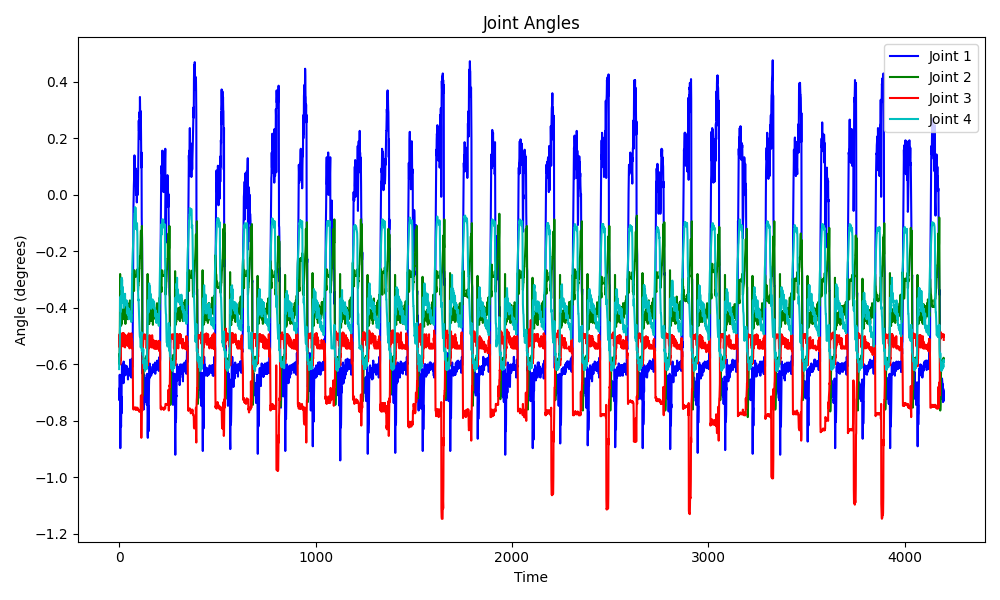

In [56]:
plot_joint_angles(Joint_tor_rf_scaled)

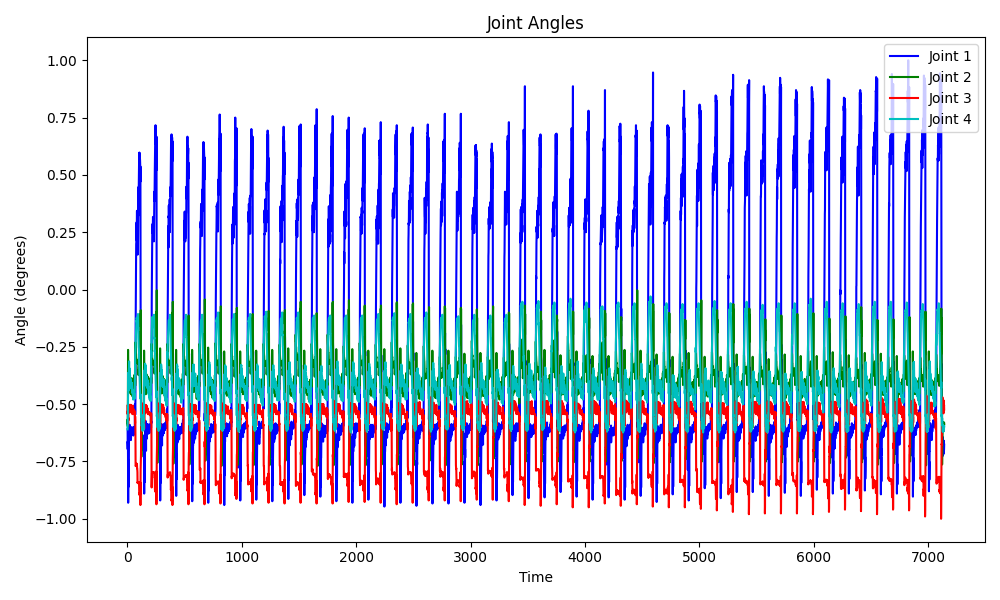

In [44]:
plot_joint_angles(Joint_tor_scaled)

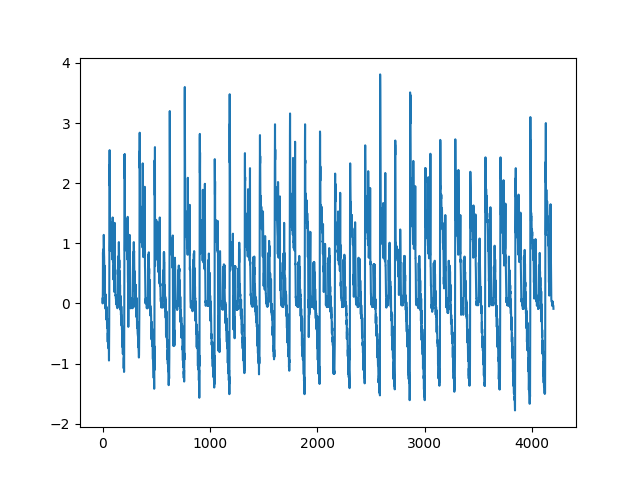

In [40]:
plt.close('all')
plt.plot(RF_GRF_rf[:,0])
plt.show()

In [57]:
Joint_tor_rf_scaled = scaler.transform(Joint_tor_rf.reshape(-1, 1)).reshape(-1, 4)
Joint_tor_rf_scaled.shape

(4200, 4)

In [58]:
grf_rf_predicted = esn_optimal.predict(Joint_tor_rf_scaled)

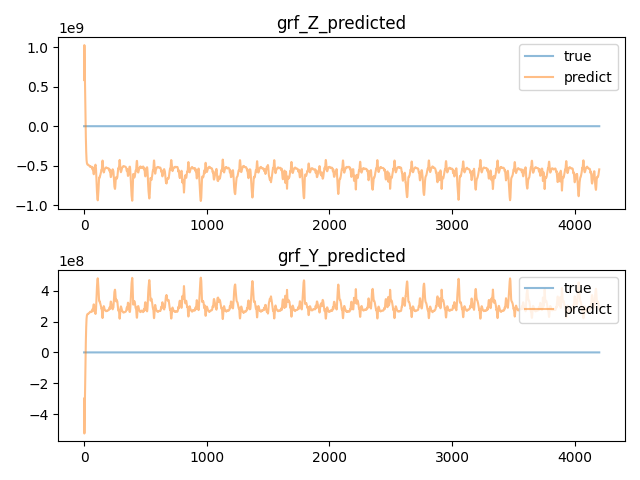

In [59]:
plt.close('all')
plt.subplot(2,1,1)
plt.plot(RF_GRF_rf[:,0], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_rf_predicted[:,0], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Z_predicted')

plt.subplot(2,1,2)
plt.plot(RF_GRF_rf[:,1], label='true', alpha=0.5)  # Adjust transparency
plt.plot(grf_rf_predicted[:,1], label='predict', alpha=0.5)  # Adjust transparency
plt.legend(loc='upper right')
plt.title('grf_Y_predicted')
plt.tight_layout()

In [41]:
def plot_joint_angles(joint_angles, title="Joint Angles", xlabel="Time", ylabel="Angle (degrees)"):
    """
    绘制四关节角度信号
    
    参数:
        joint_angles: 形状为(n,4)的numpy数组，包含四个关节的角度数据
        title: 图表标题 (默认: "Joint Angles")
        xlabel: x轴标签 (默认: "Time")
        ylabel: y轴标签 (默认: "Angle (degrees)")
    """
    # 检查输入数据
    if not isinstance(joint_angles, np.ndarray) or joint_angles.shape[1] != 4:
        raise ValueError("输入数据必须是形状为(n,4)的numpy数组")
    
    # 创建图形和轴
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 时间轴 (假设是等间隔采样)
    time = np.arange(joint_angles.shape[0])
    
    # 为每个关节绘制曲线
    joints = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4']
    colors = ['b', 'g', 'r', 'c']  # 不同颜色区分关节
    
    for i in range(4):
        ax.plot(time, joint_angles[:, i], 
                color=colors[i], 
                label=joints[i],
                linewidth=1.5)
    
    # 添加图例和标签
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # # 添加网格
    # ax.grid(True, linestyle='--', alpha=0.6)
    
    # 自动调整布局
    plt.tight_layout()
    
    # 显示图形

In [3]:
class ESN:
    def __init__(self, input_size, reservoir_size, output_size, 
                 spectral_radius=0.95, sparsity=0.1, leak_rate=0.9, seed=42):
        if seed is not None:
            np.random.seed(seed)

        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.leak_rate = leak_rate

        # Input weights
        self.Win = np.random.uniform(-1, 1, (reservoir_size, input_size))

        # Reservoir weights
        W = np.random.rand(reservoir_size, reservoir_size) - 0.5
        mask = np.random.rand(*W.shape) < sparsity
        W *= mask  # sparsify
        eigvals = np.max(np.abs(np.linalg.eigvals(W)))
        self.Wres = W * (spectral_radius / eigvals)

        # Output weights (trained later)
        self.Wout = None

        self.state = np.zeros((reservoir_size,))

    def _update_state(self, u):
        pre_activation = np.dot(self.Win, u) + np.dot(self.Wres, self.state)
        new_state = np.tanh(pre_activation)
        self.state = (1 - self.leak_rate) * self.state + self.leak_rate * new_state
        return self.state

    def fit(self, inputs, targets, washout=50, ridge_lambda=1e-6):
        states = []
        for u in inputs:
            state = self._update_state(u)
            states.append(state)

        states = np.array(states)
        states_washed = states[washout:]
        targets_washed = targets[washout:]

        # Add bias term
        extended_states = np.hstack([states_washed, np.ones((states_washed.shape[0], 1))])
        
        # Ridge regression
        self.Wout = np.dot(np.linalg.pinv(extended_states), targets_washed)

    def predict(self, inputs):
        outputs = []
        for u in inputs:
            state = self._update_state(u)
            extended_state = np.concatenate([state, [1]])  # Add bias
            y = np.dot(extended_state, self.Wout)
            outputs.append(y)
        return np.array(outputs)

In [4]:
def plot_foot_forces(joint_angles, title="Joint Angles", xlabel="Time", ylabel="Angle (degrees)"):
    """
    绘制四关节角度信号
    
    参数:
        joint_angles: 形状为(n,4)的numpy数组，包含四个关节的角度数据
        title: 图表标题 (默认: "Joint Angles")
        xlabel: x轴标签 (默认: "Time")
        ylabel: y轴标签 (默认: "Angle (degrees)")
    """
    # 检查输入数据
    if not isinstance(joint_angles, np.ndarray) or joint_angles.shape[1] != 2:
        raise ValueError("输入数据必须是形状为(n,4)的numpy数组")
    
    # 创建图形和轴
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 时间轴 (假设是等间隔采样)
    time = np.arange(joint_angles.shape[0])
    
    # 为每个关节绘制曲线
    joints = ['Z', 'Y']
    colors = ['b', 'g']  # 不同颜色区分关节
    
    for i in range(2):
        ax.plot(time, joint_angles[:, i], 
                color=colors[i], 
                label=joints[i],
                linewidth=1.5)
    
    # 添加图例和标签
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # # 添加网格
    # ax.grid(True, linestyle='--', alpha=0.6)
    
    # 自动调整布局
    plt.tight_layout()
    
    # 显示图形